# Project: Investigate TMDb movie data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>In this dataset we will explore how different budgets perform, how releasing trends moved, and ranking directors performance.
>I will try to answer the following questions:
> * What are the most popular geners?
> * What are the most profitable geners?
> * What is the most profitable budget range?
> * What does the trend of movie releases look like?
> * The top 10 directors by sum profits?
> * What is the relation between popularity and profitability?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id='wrangling'></a>
## Data Wrangling



### General Properties

In [2]:
df = pd.read_csv('tmdb-movies.csv'); #Loading the data...
df.info() #Looking at column names and null value counts.
# Most of the columns with null values are not needed to answer my questions.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [3]:
df.describe() #Deeper look at numerical values, I see zeroes in budget and revenue at (min, 25%, 50%)!

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [4]:
print('Total zero budget: ' + str(df[df['budget_adj'] == 0].shape[0]))
print('Total zero revenue: ' + str(df[df['revenue_adj'] == 0].shape[0]))
print('Ratio of zero budget: %' + str((df[df['budget_adj'] == 0].shape[0]/df.shape[0]) * 100)[0:4])
print('Ratio of zero revenue: %' + str((df[df['revenue_adj'] == 0].shape[0]/df.shape[0]) * 100)[0:4])
print('Total zero budget and zero revenue: ' + str((df[(df['budget_adj'] == 0) & (df['revenue_adj'] == 0)].shape[0])))
# More than half of movies have 0 budget.

Total zero budget: 5696
Total zero revenue: 6016
Ratio of zero budget: %52.4
Ratio of zero revenue: %55.3
Total zero budget and zero revenue: 4701


### Data Cleaning

In [5]:
# Most of my questions rely on profitabilty data, 
# I will have to ignore records with very low budget and zero revenue when answering those questions(1, 3, 4).
profitabilty_df = df[(df['budget_adj'] > 100) & (df['revenue_adj'] > 0)] 

# Make a column for profits.
profitabilty_df['profits'] = profitabilty_df['revenue_adj'] - profitabilty_df['budget_adj']

# Drop duplicates.
profitabilty_df.drop_duplicates(inplace = True)

# Let's take a look at the filtered data set...
profitabilty_df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,profits
count,3834.000000,3834.000000,3.834000e+03,3.834000e+03,3834.000000,3834.000000,3834.000000,3834.000000,3.834000e+03,3.834000e+03,3.834000e+03
mean,39855.732916,1.195565,3.739777e+07,1.082477e+08,109.262389,530.093375,6.169484,2001.265258,4.447077e+07,1.377791e+08,9.330828e+07
std,67258.759115,1.477799,4.223234e+07,1.768278e+08,19.864385,881.580019,0.794934,11.286502,4.481161e+07,2.164473e+08,1.944613e+08
min,5.000000,0.001117,1.130000e+02,2.000000e+00,26.000000,10.000000,2.200000,1960.000000,2.248029e+02,2.370705e+00,-4.139124e+08
25%,6069.000000,0.463931,1.000000e+07,1.400000e+07,96.000000,72.000000,5.700000,1995.000000,1.329642e+07,1.875393e+07,-1.621661e+06
50%,11302.000000,0.801529,2.400000e+07,4.551682e+07,106.000000,205.500000,6.200000,2004.000000,3.029664e+07,6.206345e+07,2.788427e+07
75%,38517.750000,1.377080,5.000000e+07,1.248613e+08,119.000000,582.000000,6.700000,2010.000000,6.076720e+07,1.646624e+08,1.080047e+08
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,338.000000,9767.000000,8.400000,2015.000000,4.250000e+08,2.827124e+09,2.750137e+09


<a id='eda'></a>
## Exploratory Data Analysis

### What are the most popular geners?

In [6]:
# let's see the longest string in geners.
field_length = df.genres.astype(str).map(len)
print(df.loc[field_length.argmax(), 'genres'])
# At most, geners column can have 5 geners.

# I made a list of all geners
geners = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign',
          'Horror', 'History', 'War', 'Mystery', 'Romance', 'Thriller', 'Music', 'TV Movie', 'Western', 'Science Fiction']

# I will have to seperate the geners.
df[['g1','g2','g3','g4','g5']] = df['genres'].str.split("|",expand=True,)
profitabilty_df[['g1','g2','g3','g4','g5']] = profitabilty_df['genres'].str.split("|",expand=True,)

# I will make a binary column for each gener in 'geners' list declared in the cell above.
def reset_flags():
    for g in geners:
        df[str(g)] = 0
        profitabilty_df[str(g)] = 0
        df[str(g)][(df['g1'] == str(g)) |
                                (df['g2'] == str(g)) |
                                (df['g3'] == str(g)) |
                                (df['g4'] == str(g)) |
                                (df['g5'] == str(g))] = 1
        profitabilty_df[str(g)][(profitabilty_df['g1'] == str(g)) |
                                (profitabilty_df['g2'] == str(g)) |
                                (profitabilty_df['g3'] == str(g)) |
                                (profitabilty_df['g4'] == str(g)) |
                                (profitabilty_df['g5'] == str(g))] = 1
reset_flags()

Action|Adventure|Animation|Science Fiction|Thriller


In [7]:
# I will store each gener average popularity in a column.
for g in geners:
    df[str(g)] = df[df[str(g)] == 1]['popularity'].mean()

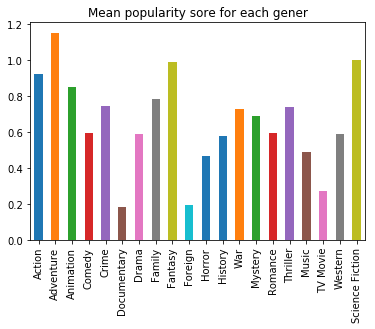

In [8]:
df.loc[0, 'Action':'Science Fiction'].plot(kind='bar', title='Mean popularity sore for each gener');

#### Reasoning 
* I thought 'Action' will be the top popular gener.
* The top 3 are Science Fiction, Adventure and Fantasy.
* The bottom 3 typicly are Foreign, Documentary and TV Movie(Low total number).

### What are the most profitable geners?

In [9]:
# I will store each gener average profits in a column.
reset_flags()
for g in geners:
    profitabilty_df[str(g)] = profitabilty_df[profitabilty_df[str(g)] == 1]['profits'].mean()

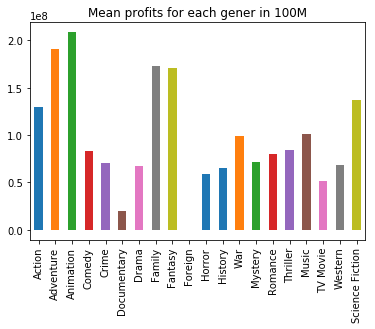

In [10]:
profitabilty_df.loc[0, 'Action':'Science Fiction'].plot(kind='bar', title='Mean profits for each gener in 100M');

#### Reasoning 
* I thought the most popular are the most profitable, but that is not the case here for some geners.
* The top 4 are Animation, Adventure, Family and Fantasy.
* The bottom 3 typicly are Foreign, Documentary and TV Movie; like the least popular ones.

### What is the most profitable budget range?

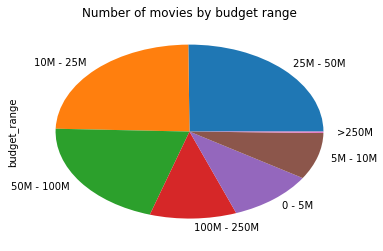

In [11]:
# I'll divide budgets into groubs to make answering the question easier.
profitabilty_df['budget_range'] = ''
profitabilty_df['budget_range'][profitabilty_df['budget_adj'] <= 5000000] = '0 - 5M'
profitabilty_df['budget_range'][profitabilty_df['budget_adj'] > 5000000] = '5M - 10M'
profitabilty_df['budget_range'][profitabilty_df['budget_adj'] > 10000000] = '10M - 25M'
profitabilty_df['budget_range'][profitabilty_df['budget_adj'] > 25000000] = '25M - 50M'
profitabilty_df['budget_range'][profitabilty_df['budget_adj'] > 50000000] = '50M - 100M'
profitabilty_df['budget_range'][profitabilty_df['budget_adj'] > 100000000] = '100M - 250M'
profitabilty_df['budget_range'][profitabilty_df['budget_adj'] > 250000000] = '>250M'

# let's see the distribution...
profitabilty_df['budget_range'].value_counts().plot(kind='pie', title='Number of movies by budget range');
# Most movies are between 10M-50M dollar budget.

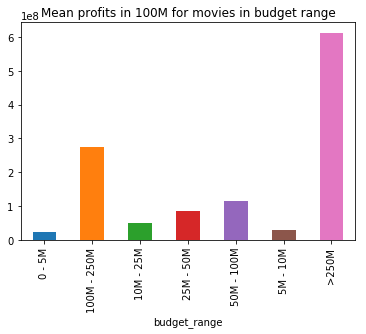

In [12]:
profitabilty_df.groupby(['budget_range'])['profits'].mean().plot(kind='bar', title='Mean profits in 100M for movies in budget range');
# Unsurprisingly, Higher budget usually brings higher profits.

#### Reasoning 
* I thought the most expensive movies will get more profits but not that much!
* The trend is clear, on average more budget means more profits.

### What does the trend of movie releases look like?

In [ ]:
profitabilty_df.groupby('release_year')['original_title'].count().plot(kind='line', title='Number of movies released each year');
# An accelerating trend slowing down near 2005.

#### Reasoning 
* I thought movies will low and rise quickly as time goes, it appears that was the case for the most part.
* What helped the medium is better internet and major platforms like Netflix(founded in 1997).

### The top 10 directors by sum profits?

In [ ]:
profitabilty_df.groupby('director')['profits'].sum().nlargest(10).plot(kind='bar', title='Sum of profits for the top 10 directors in 100M');
# The top director by far is Steven Spielberg (32 movies).

#### Reasoning 
* The first one directed the highest number of movies and was the most profitable director.
* The second 2 directors directed way less movies but did make more profit than the rest directors, less quantity more quality.

###  What is the relation between popularity and profitability?

In [ ]:
sns.regplot(x = "popularity", y="profits", data=profitabilty_df);
# I see there is a positive relationship, but it's not clean and predictable.
# I see a few unpopular movies making huge profits and highly popular movies making modest profits.

#### Reasoning 
* I thought the trend will be positive and cleaner, looks like it's just positive.

<a id='conclusions'></a>
## Conclusions

* I was a bit surprised at how ROI of some movies seemed astronomical, I got confused and I was about to delete valid entries, I checked some movies to validate and decided to adjust my cleaning conditions accordingly.
* %72 of movies with disclosed budget and revenue made positive returns.
* At least %52.4 of movies have no data about budget or revenue.

#### Limitations
* The data lack some details about popularity and how it was calculated, I read about it in this website: https://developers.themoviedb.org/3/getting-started/popularity

In [20]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0